In [62]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path
import pickle
import random

### Evaluate system performance

In [3]:
def readGroundTruthLabels(gtfile):
    d={}
    d1={}
    with open(gtfile, "r") as f:
        for line in f:
            data = line.split(',')
            key = data[0]
            d[key] = []
            d1[key] = key
            for idx,item in enumerate(data):
                if idx != 0 and item != "x":
                    try:
                        pieceNum = int(item)
                        d[key].append(pieceNum)
                    except:
                        pass
                    try:
                        pieceNum = int(item)
                        d1[str(pieceNum)] = key
                    except:
                        pass
    return d, d1

In [4]:
def readHypothesisFiles(hypdir, benchmark):
    l = []
    for hypfile in sorted(glob.glob("{}/*.hyp".format(hypdir))):
#         print(hypfile)
        with open(hypfile, "rb") as f:
            l.append(pickle.load(f))
    return l

In [5]:
s = set([])
def collapseIds(pieceScores):
    pieceScores = list(dict.fromkeys(pieceScores))
    return pieceScores
        

In [6]:
def getRank(pieceScores,gt,idt,queryid,benchmark, condition):
    query = queryid.split('_')[0]
    l = []
    count = 0
    rank = 300000
    for i in range(len(pieceScores)):
        if pieceScores[i][0][0]=='p':
            if(pieceScores[i][0]==queryid.split('_')[0]):
                rank=count+1
                return rank
            if not pieceScores[i][0] in idt.keys():
                count+=1
            elif not idt[pieceScores[i][0]] in l:
                count+=1
                l.append(idt[idt[pieceScores[i][0]]])
        else:
            try:
                if (int(pieceScores[i][0].split("_")[-1]) in gt[query]):
                    rank = count+1
                    return rank

                if not str(int(pieceScores[i][0].split("_")[-1])) in idt.keys():
                    count+=1
                elif not idt[str(int(pieceScores[i][0].split("_")[-1]))] in l:
                    count+=1
                    l.append(idt[str(int(pieceScores[i][0].split("_")[-1]))])
            except:
                pass
    return rank

In [7]:
def calcPrecisionRecall(hypdir, gtfile, benchmark = False, condition = 1):
    hyps = readHypothesisFiles(hypdir, benchmark)
    gt,idt = readGroundTruthLabels(gtfile)
    MRR = 0
    runtimes = []
    MRRs = []
    matches = []
    hyps = np.array(sorted(hyps, key = lambda x: int(x[0].split("_")[0][1:])*100+int(x[0].split("_")[1][1:])), dtype=object)
    count = 0
    if hyps.shape[1] == 2:
        for queryid, pieceScores in hyps:
            rank = getRank(pieceScores,gt,idt,queryid,benchmark, condition)
            MRRs.append((queryid,rank))
            MRR=MRR+1/(rank)
    else:
        for queryid, pieceScores, runtime, matches_processed in hyps:
            rank = getRank(pieceScores,gt,idt,queryid,benchmark, condition)
            MRRs.append((queryid,rank))
            runtimes.append(runtime)
            MRR=MRR+1/(rank)
            if matches_processed == 0:
                print(queryid)
                print(pieceScores)
            matches.append(matches_processed)
    return MRR/len(MRRs),MRRs, runtimes, matches

In [8]:
def calcOverlap(seg1, seg2):
    overlap_lb = max(seg1[0], seg2[0])
    overlap_ub = min(seg1[1], seg2[1])
    overlap = np.clip(overlap_ub - overlap_lb, 0, None)
    return overlap    

In [21]:
hypdir = 'experiments/v0.3.1_test/hyp'

#0 is normal
#1 is old paper
#2 is new paper
#3 is weird test
benchmark = 0
queryGTFile = 'piece_To_id.csv'
correct_matches = {}
MRR, MRRs, runtimes, matches_processed = calcPrecisionRecall(hypdir, queryGTFile, benchmark, condition = 1)

p76_q10
[]
p154_q10
[]
p182_q10
[]


In [22]:
MRR

0.9240200806754996

### Investigate Errors

In [12]:
def printDebuggingInfo(MRRs):
    for i, (queryid, rank) in enumerate(MRRs):
        print(queryid, rank)

In [24]:
printDebuggingInfo(MRRs)

p2_q1 1
p2_q2 1
p2_q3 1
p2_q4 1
p2_q5 1
p2_q6 1
p2_q7 1
p2_q8 1
p2_q9 1
p2_q10 1
p3_q1 1
p3_q2 2
p3_q3 1
p3_q4 1
p3_q5 1
p3_q6 1
p3_q7 1
p3_q8 1
p3_q9 1
p3_q10 2
p4_q1 1
p4_q2 9
p4_q3 5
p4_q4 1
p4_q5 1
p4_q6 1
p4_q7 1
p4_q8 1
p4_q9 1
p4_q10 1
p6_q1 1
p6_q2 1
p6_q3 1
p6_q4 1
p6_q5 1
p6_q6 1
p6_q7 1
p6_q8 1
p6_q9 1
p6_q10 1
p7_q1 1
p7_q2 1
p7_q3 1
p7_q4 1
p7_q5 1
p7_q6 1
p7_q7 1
p7_q8 1
p7_q9 1
p7_q10 1
p8_q1 1
p8_q2 1
p8_q3 1
p8_q4 1
p8_q5 1
p8_q6 1
p8_q7 1
p8_q8 1
p8_q9 1
p8_q10 1
p9_q1 1
p9_q2 1
p9_q3 1
p9_q4 1
p9_q5 1
p9_q6 1
p9_q7 1
p9_q8 1
p9_q9 1
p9_q10 1
p10_q1 1
p10_q2 1
p10_q3 1
p10_q4 1
p10_q5 1
p10_q6 1
p10_q7 1
p10_q8 1
p10_q9 1
p10_q10 1
p12_q1 1
p12_q2 1
p12_q3 1
p12_q4 1
p12_q5 1
p12_q6 1
p12_q7 1
p12_q8 1
p12_q9 1
p12_q10 1
p13_q1 1
p13_q2 1
p13_q3 3222
p13_q4 1
p13_q5 1
p13_q6 1
p13_q7 1
p13_q8 1
p13_q9 1
p13_q10 1
p14_q1 1
p14_q2 1
p14_q3 1
p14_q4 1
p14_q5 1
p14_q6 1
p14_q7 26
p14_q8 1
p14_q9 1
p14_q10 1
p16_q1 1
p16_q2 1
p16_q3 1
p16_q4 1
p16_q5 1
p16_q6 1
p16_q7 1
p1

p173_q9 1
p173_q10 1
p174_q1 1
p174_q2 1
p174_q3 1
p174_q4 1
p174_q5 1
p174_q6 1
p174_q7 1
p174_q8 1
p174_q9 1
p174_q10 1
p176_q1 1
p176_q2 1
p176_q3 1
p176_q4 1
p176_q5 1
p176_q6 1
p176_q7 1
p176_q8 1
p176_q9 1
p176_q10 1
p177_q1 1
p177_q2 1
p177_q3 1
p177_q4 1
p177_q5 1
p177_q6 1
p177_q7 1
p177_q8 1
p177_q9 1
p177_q10 1
p178_q1 1
p178_q2 1
p178_q3 1
p178_q4 1
p178_q5 1
p178_q6 1
p178_q7 1
p178_q8 1
p178_q9 1
p178_q10 1
p179_q1 1
p179_q2 1
p179_q3 1
p179_q4 1
p179_q5 1
p179_q6 1
p179_q7 1
p179_q8 1
p179_q9 3
p179_q10 1
p180_q1 1
p180_q2 1
p180_q3 1
p180_q4 1
p180_q5 1
p180_q6 1
p180_q7 2
p180_q8 1
p180_q9 1
p180_q10 1
p182_q1 1
p182_q2 1
p182_q3 1
p182_q4 1
p182_q5 1
p182_q6 1
p182_q7 1
p182_q8 1
p182_q9 1
p182_q10 300000
p183_q1 1
p183_q2 1
p183_q3 1
p183_q4 1
p183_q5 1
p183_q6 1
p183_q7 1
p183_q8 1
p183_q9 1
p183_q10 1
p184_q1 1
p184_q2 1
p184_q3 1
p184_q4 1
p184_q5 1
p184_q6 1
p184_q7 1
p184_q8 1
p184_q9 21
p184_q10 1
p186_q1 1
p186_q2 1
p186_q3 1
p186_q4 1
p186_q5 1
p186_q6 1
p186

In [13]:
printDebuggingInfo(MRRs)

p1_q1 1
p1_q2 1
p1_q3 1
p1_q4 1
p1_q5 1
p1_q6 1
p1_q7 1
p1_q8 1
p1_q9 1
p1_q10 1
p5_q1 1
p5_q2 1
p5_q3 1
p5_q4 1
p5_q5 1
p5_q6 1
p5_q7 1
p5_q8 1
p5_q9 1
p5_q10 1
p11_q1 1
p11_q2 1
p11_q3 1
p11_q4 1
p11_q5 1
p11_q6 1
p11_q7 1
p11_q8 1
p11_q9 1
p11_q10 1
p15_q1 1
p15_q2 1
p15_q3 1
p15_q4 1
p15_q5 1
p15_q6 1
p15_q7 1
p15_q8 1
p15_q9 1
p15_q10 1
p21_q1 1
p21_q2 1
p21_q3 1
p21_q4 1
p21_q5 1
p21_q6 1
p21_q7 1
p21_q8 1
p21_q9 1
p21_q10 1
p25_q1 1
p25_q2 1
p25_q3 1
p25_q4 1
p25_q5 1
p25_q6 1
p25_q7 1
p25_q8 1
p25_q9 1
p25_q10 1
p31_q1 1
p31_q2 1
p31_q3 1
p31_q4 1
p31_q5 1
p31_q6 1
p31_q7 1
p31_q8 1
p31_q9 1
p31_q10 1
p35_q1 1
p35_q2 1
p35_q3 1
p35_q4 1
p35_q5 1
p35_q6 1
p35_q7 1
p35_q8 1
p35_q9 1
p35_q10 1
p41_q1 474
p41_q2 1
p41_q3 1
p41_q4 1
p41_q5 1
p41_q6 1
p41_q7 1
p41_q8 1
p41_q9 1
p41_q10 1
p45_q1 1
p45_q2 1
p45_q3 1
p45_q4 15092
p45_q5 1
p45_q6 1
p45_q7 1
p45_q8 1
p45_q9 1
p45_q10 1
p51_q1 1
p51_q2 1
p51_q3 1
p51_q4 1
p51_q5 1
p51_q6 1
p51_q7 1
p51_q8 1
p51_q9 1
p51_q10 11946
p55_q1 1


In [15]:
def get_worst_results(MRRs):
    for i, (queryid, rank) in enumerate(MRRs):
        if rank != 1:
            print(queryid, rank)

In [16]:
get_worst_results(MRRs)

p41_q1 474
p45_q4 15092
p51_q10 11946
p91_q3 2
p101_q10 47
p111_q1 43
p111_q2 10435
p111_q7 56
p111_q9 53
p115_q1 2
p115_q2 39
p115_q3 3
p115_q4 6
p115_q6 2079
p115_q9 12
p135_q4 3380
p135_q6 55
p145_q4 2820
p145_q10 813
p155_q7 300000
p161_q1 300000
p165_q4 454
p165_q8 87
p175_q1 7
p175_q2 2
p175_q3 2
p175_q4 8
p175_q6 2
p175_q8 2
p175_q9 4
p181_q9 1396
p185_q7 572


### Measure Runtime

In [72]:
def showRuntimeStats(durs):
    durs = np.array(durs)
    avgDur = np.mean(durs)
    minDur = np.min(durs)
    maxDur = np.max(durs)
    stdDur = np.std(durs)
    print('Avg Duration: {:.2f} sec'.format(avgDur))
    print('Std Duration: {:.2f} sec'.format(stdDur))
    print('Min Duration: {:.2f} sec'.format(minDur))
    print('Max Duration: {:.2f} sec'.format(maxDur))
    plt.hist(durs, bins=np.arange(0,2,.1))
    plt.xlabel('Runtime (sec)')
    plt.ylabel('Count')

In [21]:
def showRuntimeStats(durs):
    durs = np.array(durs)
    avgDur = np.mean(durs)
    minDur = np.min(durs)
    maxDur = np.max(durs)
    stdDur = np.std(durs)
    print('Avg Duration: {:.2f} sec'.format(avgDur))
    print('Std Duration: {:.2f} sec'.format(stdDur))
    print('Min Duration: {:.2f} sec'.format(minDur))
    print('Max Duration: {:.2f} sec'.format(maxDur))
    plt.hist(durs, bins=np.arange(0,maxDur,3))
    plt.xlabel('Runtime (sec)')
    plt.ylabel('Count')

Avg Duration: 0.70 sec
Std Duration: 0.14 sec
Min Duration: 0.22 sec
Max Duration: 1.31 sec


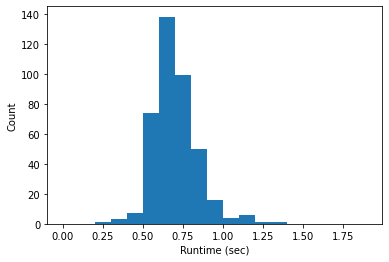

In [73]:
showRuntimeStats(runtimes)

### Measure matches processed

In [75]:
def showMatchStats(matchesProcessed):
    matches = np.array(matchesProcessed)
    avgMatches = np.mean(matches)
    minMatches = np.min(matches)
    maxMatches = np.max(matches)
    stdMatches = np.std(matches)
    print(f'Avg Matches: {avgMatches}')
    print(f'Std Matches: {stdMatches}')
    print(f'Min Matches: {minMatches}')
    print(f'Max Matches: {maxMatches}')
    plt.hist(matches)
    plt.xlabel('Number of matches processed')
    plt.ylabel('Count')

Avg Matches: 1070.5975
Std Matches: 776.3220790971683
Min Matches: 0
Max Matches: 4486


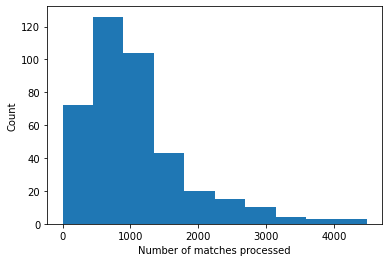

In [76]:
showMatchStats(matches_processed)